In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

In [2]:
# movies = pd.read_csv('./data/tmdb_5000_movies.csv').head(n=1)
# credits = pd.read_csv('./data/tmdb_5000_credits.csv').head(n=1)
movies = pd.read_csv('./data/tmdb_5000_movies.csv')
credits = pd.read_csv('./data/tmdb_5000_credits.csv')

In [3]:
movies.shape

(4803, 20)

In [4]:
movies.head(n=1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [5]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies = pd.merge(left=movies, right=credits, left_on='id', right_on='movie_id')

In [7]:
# turn json into python objects
json_columns = ['genres', 'keywords', 'production_countries', 'spoken_languages', 'cast', 'crew']
for column in json_columns:
    movies[column] = movies[column].apply(json.loads, encoding="utf-8")

In [8]:
movies.cast[0][:2]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1}]

In [9]:
movies.genres[0][0]['name']

'Action'

In [10]:
def actor_to_id_string(actor):
    return '{} - {}'.format(actor['name'], actor['id'])

In [11]:
def cast_to_actors(cast):
    actors = []
    for person in cast:
        actors.append(actor_to_id_string(person))
    return actors

In [12]:
movies.actors = movies.cast.apply(cast_to_actors)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


### Create list of all actors

In [13]:
all_actors = []
for actors in movies.actors:
    for actor in actors:
        all_actors.append(actor)

In [14]:
actors = pd.Series(all_actors)

In [15]:
unique_actors_count = pd.crosstab(actors, columns='count')

unique_actors_count \
.sort_values(by='count', ascending=False).head(12)

col_0,count
row_0,
Samuel L. Jackson - 2231,67
Robert De Niro - 380,57
Bruce Willis - 62,51
Matt Damon - 1892,48
Morgan Freeman - 192,46
Steve Buscemi - 884,43
Liam Neeson - 3896,41
Johnny Depp - 85,40
Owen Wilson - 887,40


#### Total Number of unique actors

In [16]:
len(unique_actors_count)

54588

In [17]:
#### Total Number of actors that show up more than once

In [18]:
len(unique_actors_count[unique_actors_count.values > 1])

15661

In [19]:
#### Total Number of actors that show up more than three times

In [20]:
len(unique_actors_count[unique_actors_count.values > 3])

5326

In [21]:
sam_count = unique_actors_count[unique_actors_count.index == 'Samuel L. Jackson - 2231']
sam_count

col_0,count
row_0,
Samuel L. Jackson - 2231,67


In [22]:
sam_count.values[0][0]

67

### Create Actors Features

In [23]:
actors_string_id_by_id = {}
actor_counts_by_string_id = {}
unique_actors_count_dict = unique_actors_count.to_dict()['count']

def actor_has_more_than_x_movies(actor, number_of_movies = 3):
    string_id = str(actor['id'])

    # First, get the unique id created for the actor
    actor_string_id = ''
    if string_id in actors_string_id_by_id:
        actor_string_id = actors_string_id_by_id[string_id]
    else:
        actor_string_id = actor_to_id_string(actor)
        actors_string_id_by_id[string_id] = actor_string_id
    
    # Now let's see how many movies this actor has played in
    actor_count = unique_actors_count_dict[actor_string_id]
    return actor_count > number_of_movies

In [24]:
actor_has_more_than_x_movies(movies.cast[0][2], 1)

True

#### Create a new feature that represents all actors that show up in more than 3 movies

In [25]:
movies_actors_ids = []
for actors in movies.cast:
    movie_actors_ids = []
    for actor in actors:
        if (not actor_has_more_than_x_movies(actor, 3)):
            continue
        movie_actors_ids.append(str(actor['id']))
    movies_actors_ids.append(' '.join(movie_actors_ids))

## Actor Vectorization

In [26]:
vectorizer = CountVectorizer()

movie_vector = vectorizer.fit_transform(movies_actors_ids).toarray()
actor_feature_names = vectorizer.get_feature_names()
actor_vector_works = pd.DataFrame(movie_vector, columns=actor_feature_names)
actor_vector_works['id'] = movies.id

### label records as having Samuel L. Jackson

In [27]:
movies.samuel = actor_vector_works['2231'] == 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [28]:
actor_vector_works.shape

(4803, 5321)

In [29]:
movies_with_samuel = movies[movies.samuel == True]

#### There should be 67 movies with Samuel L Jackson

In [30]:
len(movies_with_samuel)

67

In [31]:
baseline_prediction = len(movies_with_samuel) / len(movies)
1 - baseline_prediction

0.9860503851759317

# Genres

In [32]:
movies.genres.head()

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
3    [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
4    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object

In [33]:
movies.genres[0][0]

{'id': 28, 'name': 'Action'}

In [34]:
def unique_genres(movies_genres):
    genre_map = {}
    for genres in movies_genres:
        for genre in genres:
            name = genre['name']
            if not name in genre_map:
                genre_map[name] = 0
            genre_map[name]+=1
    return pd.Series(genre_map).sort_values(ascending=False)

### All Unique Genres

In [35]:
unique_genres(movies.genres)

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
dtype: int64

### Genres which Samuel is in

In [36]:
movies_merge = pd.merge(left=movies, right=actor_vector_works, left_on='id', right_on='id')
movies_with_samuel = movies_merge[movies_merge['2231'] == 1]
unique_genres(movies_with_samuel['genres'])

Action             35
Crime              25
Thriller           25
Drama              25
Adventure          20
Science Fiction    17
Comedy             13
Mystery             8
Romance             7
Animation           4
Family              4
Western             2
Documentary         2
Horror              2
Music               2
Fantasy             2
War                 1
dtype: int64

### Number of genres in movie

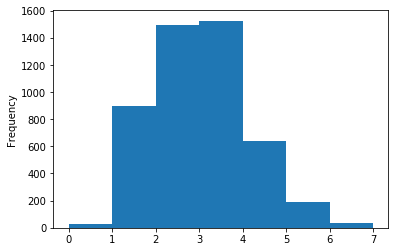

In [37]:
number_genres = movies.genres.apply(len)
number_genres.plot.hist(bins=np.max(number_genres))
plt.show()

## Genre Vectorization

In [38]:
movies_genres_ids = []
for genres in movies.genres:
    movie_genres_ids = []
    for genre in genres:
        movie_genres_ids.append(str(genre['id']))
    movies_genres_ids.append(' '.join(movie_genres_ids))

In [39]:
genre_vectorization = CountVectorizer()

movie_vector = genre_vectorization.fit_transform(movies_genres_ids).toarray()
genre_feature_names = genre_vectorization.get_feature_names()
genre_vector = pd.DataFrame(movie_vector, columns=genre_feature_names)
genre_vector['id'] = movies.id

### Normalize Movie Features

In [40]:
features_to_normalize = [
    'budget',
    'popularity',
    'vote_average',
    'vote_count',
    'revenue'
]

In [41]:
for feature in features_to_normalize:
    feature_array = movies[feature].values.astype('float64').reshape(1, -1)
    #print(len(normalize(feature_array, axis=1)[0]))
    movies[feature] = normalize(feature_array, axis=1)[0]

In [42]:
movies[features_to_normalize]

,budget,popularity,vote_average,vote_count,revenue
0,6.837300e-02,0.056539,0.016734,0.120387,0.220503
1,8.654811e-02,0.052272,0.016037,0.045910,0.076007
2,7.068095e-02,0.040356,0.014643,0.045563,0.069654
3,7.212342e-02,0.042211,0.017664,0.092902,0.085809
4,7.500836e-02,0.016509,0.014178,0.021670,0.022473
5,7.443137e-02,0.043484,0.013713,0.036483,0.070460
6,7.500836e-02,0.018296,0.017199,0.033974,0.046806
7,8.077823e-02,0.050466,0.016967,0.069039,0.111155
8,7.212342e-02,0.037164,0.017199,0.054001,0.073868
9,7.212342e-02,0.058551,0.013248,0.071457,0.069067


# Create x/y

In [43]:
important_features = features_to_normalize + ['id']

movies_with_important_features = movies[important_features]
y = movies.samuel
x = pd.merge(left=movies_with_important_features, right=actor_vector_works, left_on='id', right_on='id')
len(x.columns)

5326

#### Merge in Genres

In [44]:
x = pd.merge(left=x, right=genre_vector, left_on='id', right_on='id')
len(x.columns)

5346

### Remove id as a feature

In [45]:
x = x[x.columns.difference(['id'])]
len(x.columns)

5345

### Remove Samuel from actors

In [46]:
def remove_samuel(x):
    return x[x.columns.difference(['2231'])]
x = remove_samuel(x)
len(x.columns)

5344

### Create Cross-validation (20% holdout)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=3)

In [48]:
X_train.shape, y_train.shape

((3842, 5344), (3842,))

## Get Accuracy

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

In [50]:
def show_confusion_matrix(y, predict_true, x):
    cm = confusion_matrix(y, predict_true)
    cm = pd.DataFrame(cm)
    cm.columns = ['Negative', 'Positive']
    cm.index = ['Negative', 'Positive']
    print(cm)
    
    return
    cmap=plt.cm.Blues
    classes = x.columns
    tick_marks = np.arange(len(classes))
    title = 'Confusion Matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [51]:
def get_accuracy(model, x, y):
    predict_true = np.zeros(len(y))
    if hasattr(model, 'predict'):
        predict_true = model.predict(x)
    else:
        predict_true = model.fit_predict(x)
    print('Number of positive predictions {}'.format(len(predict_true[predict_true == True])))
    print('')
    print('Accuracy {}'.format(accuracy_score(y, predict_true)))
    print('')
    show_confusion_matrix(y, predict_true, x)

# Naive Bayes Classifications

In [52]:
bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
print('Accuracy of Training Data')
get_accuracy(bayes_model, X_train, y_train)

Accuracy of Training Data
Number of positive predictions 41

Accuracy 0.991410723581468

          Negative  Positive
Negative      3777         9
Positive        24        32


In [54]:
print('Accuracy of Test Data')
get_accuracy(bayes_model, X_test, y_test)

Accuracy of Test Data
Number of positive predictions 5

Accuracy 0.9854318418314256

          Negative  Positive
Negative       946         4
Positive        10         1


# Deep Learning (Dense Layers)

In [56]:
from keras import models, layers

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [101]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [102]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
3842/3842 [==============================] - 1s 266us/step - loss: 0.2146 - acc: 0.9763
Epoch 2/10
3842/3842 [==============================] - 1s 166us/step - loss: 0.0745 - acc: 0.9854
Epoch 3/10
3842/3842 [==============================] - 1s 166us/step - loss: 0.0544 - acc: 0.9854
Epoch 4/10
3842/3842 [==============================] - 1s 173us/step - loss: 0.0403 - acc: 0.9867
Epoch 5/10
3842/3842 [==============================] - 1s 174us/step - loss: 0.0301 - acc: 0.9880
Epoch 6/10
3842/3842 [==============================] - 1s 168us/step - loss: 0.0217 - acc: 0.9925
Epoch 7/10
3842/3842 [==============================] - 1s 176us/step - loss: 0.0155 - acc: 0.9951
Epoch 8/10
3842/3842 [==============================] - 1s 171us/step - loss: 0.0103 - acc: 0.9979
Epoch 9/10
3842/3842 [==============================] - 1s 171us/step - loss: 0.0064 - acc: 0.9987
Epoch 10/10
3842/3842 [==============================] - 1s 182us/step - loss: 0.0039 - acc: 0.9992


In [103]:
model.evaluate(X_test, y_test)

961/961 [==============================] - 0s 227us/step


[0.15724523771784488, 0.9875130072840791]

In [104]:
confusion_matrix(y_test, model.predict_classes(X_test) == 1)

array([[949,   1],
       [ 11,   0]])

# Deep Learning (CNN)

In [105]:
#model = models.Sequential()
#model.add(layers.SeparableConv2D())

### Hierarchical Clustering

In [57]:
# from sklearn.cluster import AgglomerativeClustering
# cluster_model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
# cluster_model.fit(X_train, y_train)

In [58]:
# print('Accuracy of Training Data')
# get_accuracy(cluster_model, X_train, y_train)

In [59]:
# print('Accuracy of Test Data')
# get_accuracy(cluster_model, X_test, y_test)

# TODO

Perform deap learning prediction https://www.kaggle.com/liwste/simple-deep-mlp-with-keras